In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
from copy import deepcopy
import datetime
from datetime import date

In [3]:
sys.path.insert(1, '/Users/punitaverma/Desktop/AI Masters/705.603/workspace/verma-705.603spring24/FraudDetection')
df = pd.read_csv('/Users/punitaverma/Desktop/AI Masters/705.603/workspace/verma-705.603spring24/FraudDetection/transactions.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,sex,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [13]:
df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
sex                       object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [9]:
df["is_fraud"].value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

# 1. What is the distribution between fraudulent and non-fraudulent transactions?

([<matplotlib.patches.Wedge at 0x7f8422a36d10>,
 [Text(-1.0998526550731058, 0.0180038087259363, 'Not fraud'),
  Text(1.099852653519154, -0.01800390365660262, 'Is fraud')],
 [Text(-0.5999196300398758, 0.009820259305056164, '99.479%'),
  Text(0.5999196291922657, -0.00982031108541961, '0.521%')])

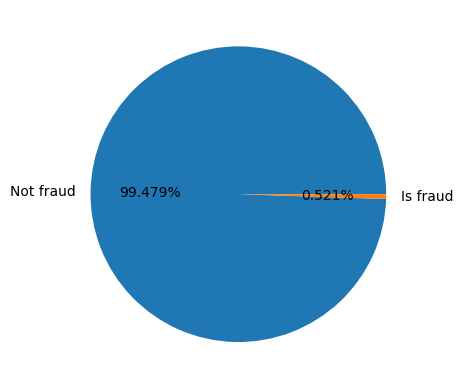

In [5]:
#plt.hist(df["is_fraud"].value_counts())
plt.pie(df["is_fraud"].value_counts(), labels=['Not fraud', 'Is fraud'], autopct='%1.3f%%')

The data in very unbalanced. In the training dataset, 99.479% of the transactions are non-fraudulent transactions and only less than 1% are fraudulent ones. This insight into the data target class distribution will command which models and metrics as best applicable to the problem.

## 2. Which age groups are more susceptible to fraudulent transactions?

In [6]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [7]:
df["age"]=[calculate_age(datetime.datetime.strptime(x, '%Y-%m-%d')) for x in df["dob"]]

In [8]:
bins = [18, 30, 40, 50, 60, 70, 120]
labels = ['18-30', '31-40', '41-50', '51-60', '61-70', '70+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

fraud_by_age = df.groupby('age_group')['is_fraud'].mean() * 100
print(fraud_by_age)

age_group
18-30    0.552785
31-40    0.435792
41-50    0.401973
51-60    0.517015
61-70    0.674943
70+      0.675699
Name: is_fraud, dtype: float64


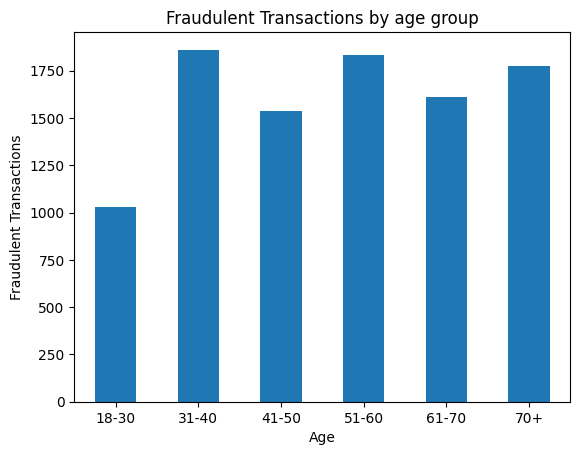

In [9]:
fraud_counts_by_age = df[df['is_fraud'] == 1].groupby('age_group').size()
fraud_counts_by_age.plot(kind='bar')

plt.title('Fraudulent Transactions by age group')
plt.xlabel('Age')
plt.ylabel('Fraudulent Transactions')
plt.xticks(rotation=0)
plt.show()

To address this question, first we need to create age groups. I used the **dob** feature and a helper function called **calculate_age** to get the ages of cardholders. Then I binned them into a new feature, **age_groups**. The plot show that although there is not a clear pattern/there is a pattern, higher ages are more susceptible to fraudulent transactions than lower ones. This is a useful insight that can guide the model training. We can  also see ages 31-40 and 51-60 have the highest rates of fraudulent transactions.

# 3. If a fraudulent transaction has been committed, what is the expected number of transaction committed per day with the same victim? 
# (Temporal component asking do fraudulent transactions occur multiple times on the same customer)


In [10]:
# df.dtypes

Average number of transactions committed per day with the same victim:  5.008303061754022


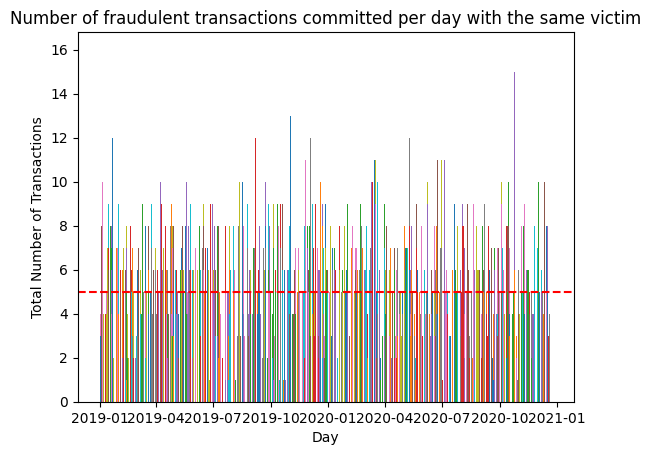

In [4]:
#transactions that are fraudulent everyday per customer
df_copy = deepcopy(df)
df_copy = df_copy[df_copy['is_fraud'] == 1]
df_copy['trans_date'] = pd.to_datetime(df_copy['trans_date_trans_time']).dt.date

total_transactions_per_day = df_copy.groupby(['cc_num', 'trans_date']).size().reset_index(name='total_transactions')

for victim in total_transactions_per_day['cc_num'].unique()[:]:
    victim_trans = total_transactions_per_day[total_transactions_per_day['cc_num'] == victim]
    plt.bar(victim_trans['trans_date'], victim_trans['total_transactions'], label=f'Victim {victim}')

plt.title('Number of fraudulent transactions committed per day with the same victim')
plt.xlabel('Day')
plt.ylabel('Total Number of Transactions')
plt.axhline(total_transactions_per_day['total_transactions'].mean(), color='red', linestyle='--', label=f'Mean Transactions ({total_transactions_per_day["total_transactions"].mean():.2f})')
print("Average number of transactions committed per day with the same victim: ", total_transactions_per_day['total_transactions'].mean()) 
# plt.legend()
plt.show()

Fraudulent transactions may potentially occur at a higher rate on the same card/victim on the same date. The average daily fraudulent transaction per customer is about 5.

# 4. For each purchase "category," plot the mean and standard "amt" between fraudulent transactions and non-fraudulent transactions

In [12]:
 # df.dtypes
# df["category"].unique()

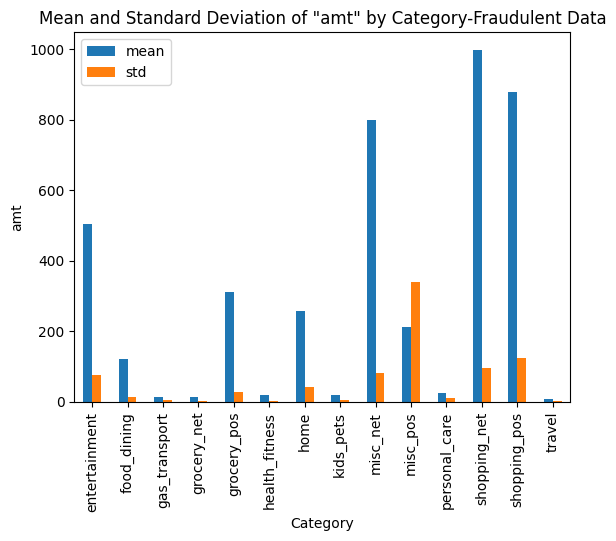

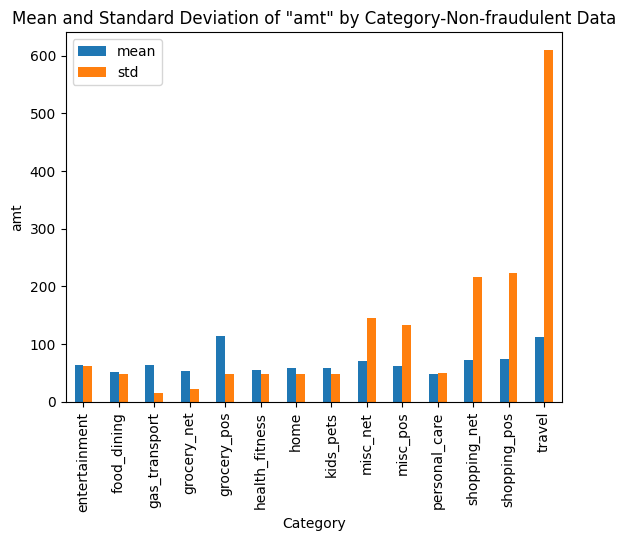

In [13]:
df_copy = deepcopy(df)
df_copy['trans_date_trans_time'] = pd.to_datetime(df_copy['trans_date_trans_time'])
df_copy['trans_date'] = [x.date() for x in df_copy['trans_date_trans_time']]

fraudulent_data = df[(df['is_fraud'] == 1)]
non_fraudulent_data = df[(df['is_fraud'] == 0)]

fraudulent_grouped = fraudulent_data.groupby('category')['amt'].agg(['mean', 'std'])
non_fraudulent_grouped = non_fraudulent_data.groupby('category')['amt'].agg(['mean', 'std'])

fraudulent_grouped.plot(kind='bar', y=['mean', 'std'])
plt.title('Mean and Standard Deviation of "amt" by Category-Fraudulent Data')
plt.xlabel('Category')
plt.ylabel('amt')
plt.show()

non_fraudulent_grouped.plot(kind='bar', y=['mean', 'std'])
plt.title('Mean and Standard Deviation of "amt" by Category-Non-fraudulent Data')
plt.xlabel('Category')
plt.ylabel('amt')
plt.show()


For each purchase category, the mean and standard ‘amt’ are plotted for fraudulent and non-fraudulent transactions. I see a pattern that fraudulent transactions have higher means. Likely, fraudulent purchase are for larger amount across categories. A pattern I observe is that the mean for non-fraudulent purchases is likely within 3 standard deviations itself. This is not the case for fraudulent transactions. Encoding this pattern and adding it to the dataset as a new feature might be usefule for the model.

# 5. What is the distribution between time transactions between fraudulent transactions and non-fraudulent transactions? What is the most likely time of a fraudulent transaction?

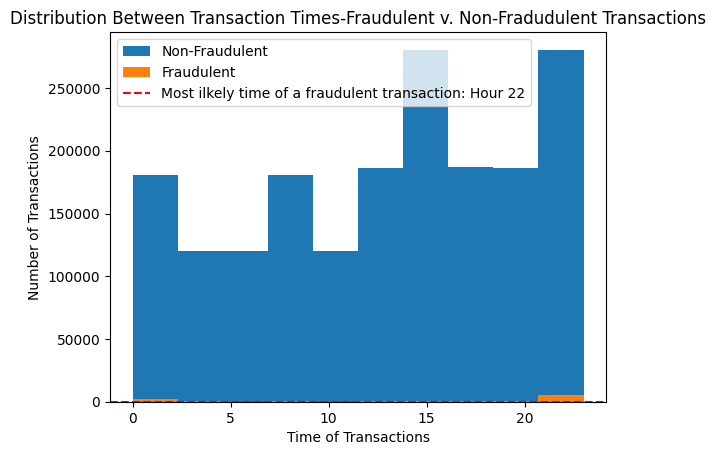

[22]


In [14]:
df_copy['hour_of_day'] = df_copy['trans_date_trans_time'].dt.hour

fraudulent_times = df_copy[df_copy['is_fraud'] == 1]['hour_of_day']
non_fraudulent_times = df_copy[df_copy['is_fraud'] == 0]['hour_of_day']

plt.hist(non_fraudulent_times,label='Non-Fraudulent')
plt.hist(fraudulent_times,label='Fraudulent')

plt.title('Distribution Between Transaction Times-Fraudulent v. Non-Fradudulent Transactions')
plt.xlabel('Time of Transactions')
plt.ylabel('Number of Transactions')
plt.axhline(fraudulent_times.mode().values[0], color='red', linestyle='--', label=f'Most ilkely time of a fraudulent transaction: Hour {fraudulent_times.mode().values[0]}')
plt.legend()
plt.show()

# Most likely time of a fraudulent transaction
print(fraudulent_times.mode().values)

The distribution between time of transactions between fraudulent and non-fraudulent transactions is plotted above.  The most likely time of a fraudulent transaction is at hour 22.

# 6. Is there a relationship between the distance between customer location (lat/lon) and merchant location (merch_lat/merch_lon) and fraudulent transaction

In [15]:
# %pip install geopy

In [16]:
from geopy import distance

dist = []
for index, row in df.iterrows():
    dist.append(distance.geodesic((row["lat"], row["long"]),(row["merch_lat"], row["merch_long"])).km)

In [17]:
df["merch_cust_dist"] = dist

In [18]:
# len(df[df['is_fraud'] == 0]['merch_cust_dist'])

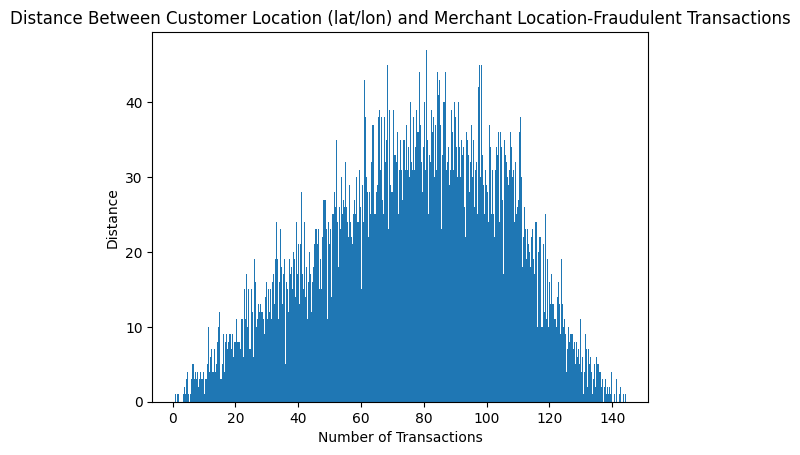

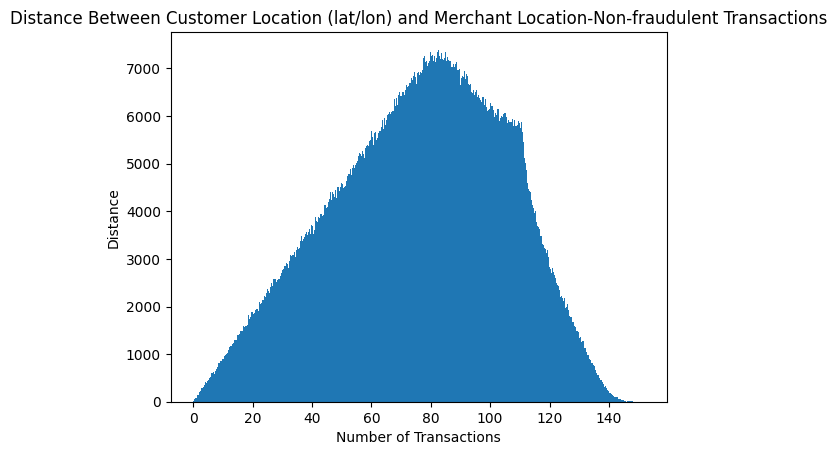

In [19]:
df[df['is_fraud'] == 1]['merch_cust_dist'].plot(kind="hist", bins=500)
plt.title('Distance Between Customer Location (lat/lon) and Merchant Location-Fraudulent Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Distance')
plt.show()


df[df['is_fraud'] == 0]['merch_cust_dist'].plot(kind="hist", bins=500)
plt.title('Distance Between Customer Location (lat/lon) and Merchant Location-Non-fraudulent Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Distance')
plt.show()

For fraudulent transactions, there appears to be a much lower distance between the merchant and customer location than there is for non-fraudulent transactions.

# 7. Are certain states, cities, and zip codes more susceptible to fraudulent transactions?

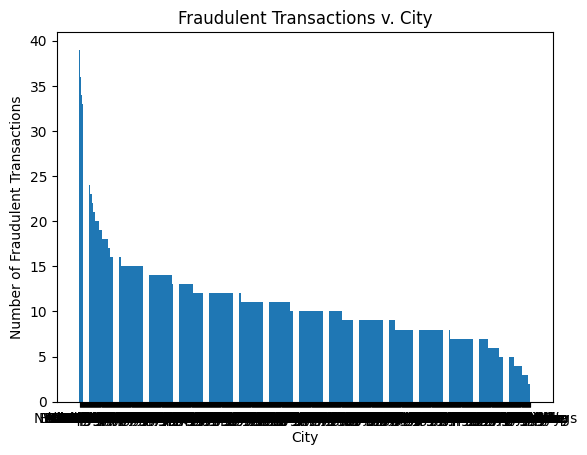

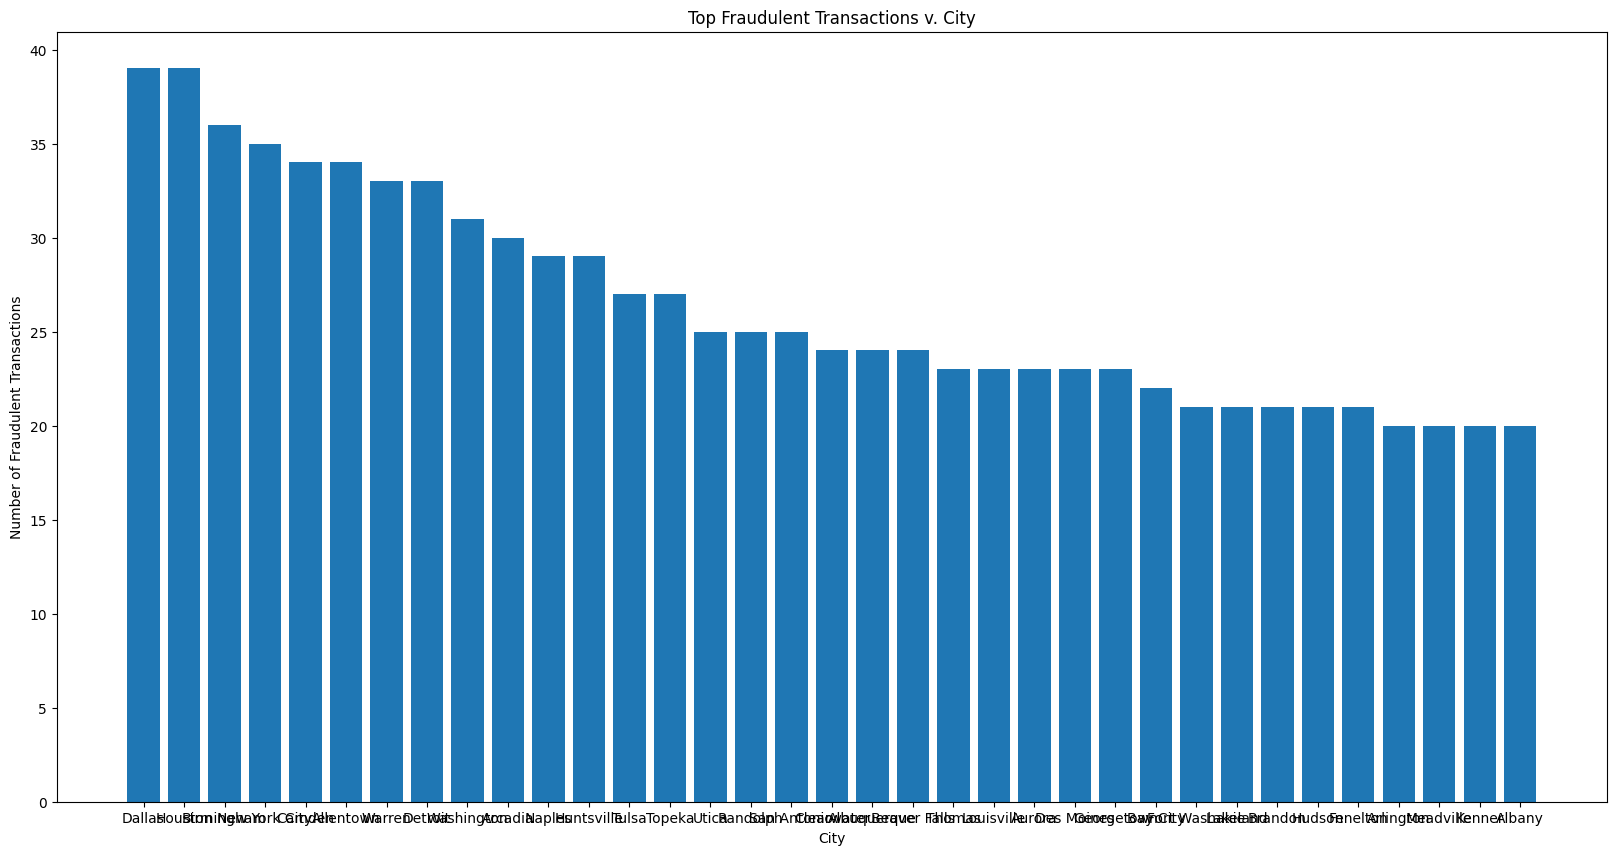

In [20]:
fraudulent_transactions_by_city = df[df['is_fraud'] == 1].groupby('city')['is_fraud'].count().sort_values(ascending=False)
plt.bar(fraudulent_transactions_by_city.index, fraudulent_transactions_by_city.values)
plt.title('Fraudulent Transactions v. City')
plt.xlabel('City')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

plt.figure(figsize=(20,10))
plt.bar(fraudulent_transactions_by_city.index[:35], fraudulent_transactions_by_city.values[:35])
plt.title('Top Fraudulent Transactions v. City')
plt.xlabel('City')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()


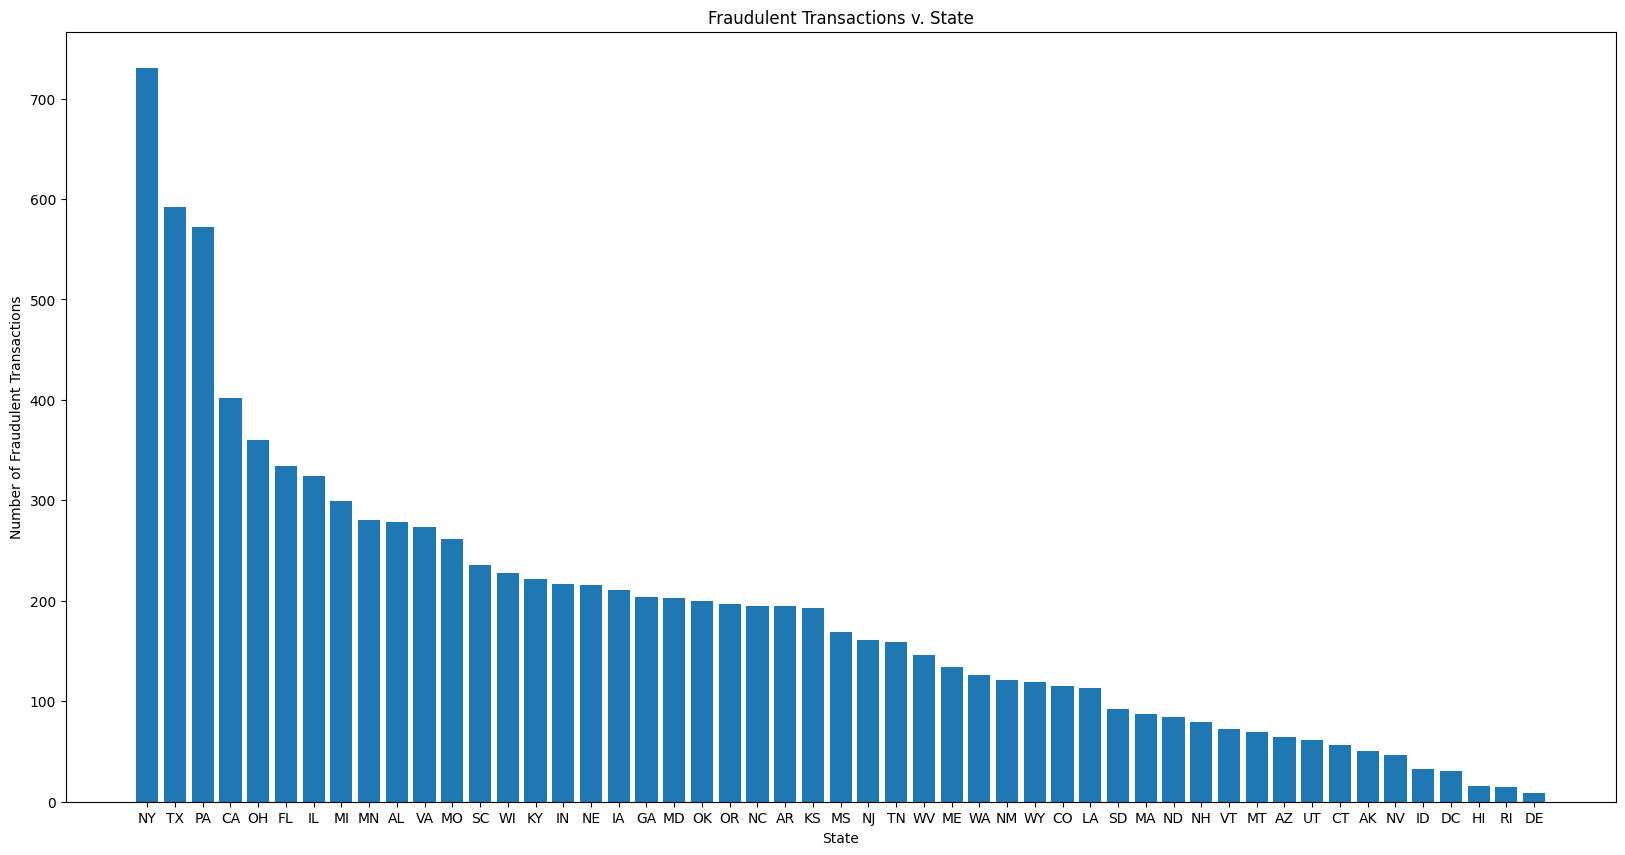

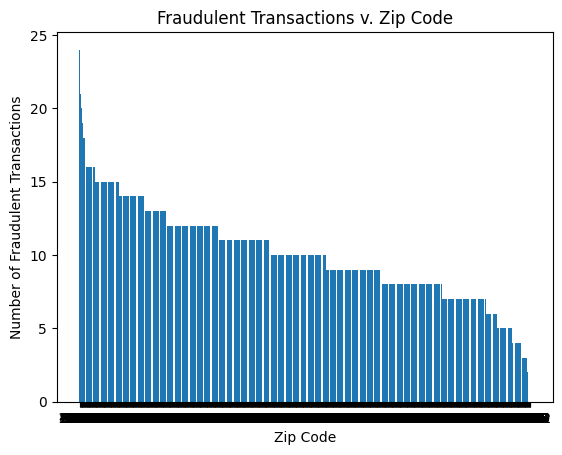

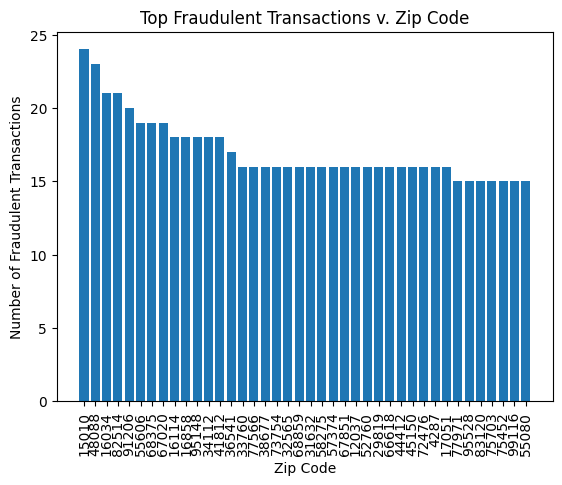

In [21]:
fraud_state = df[df['is_fraud'] == 1].groupby('state')['is_fraud'].count().sort_values(ascending=False)

plt.figure(figsize=(20,10))
plt.bar(fraud_state.index, fraud_state.values)
plt.title('Fraudulent Transactions v. State')
plt.xlabel('State')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

fraud_zc = df[df['is_fraud'] == 1].groupby('zip')['is_fraud'].count().sort_values(ascending=False)

plt.bar(fraud_zc.index.astype(str), fraud_zc.values)
plt.title('Fraudulent Transactions v. Zip Code')
plt.xlabel('Zip Code')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

plt.bar(fraud_zc.index.astype(str)[:40], fraud_zc.values[:40])
plt.title('Top Fraudulent Transactions v. Zip Code')
plt.xlabel('Zip Code')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=90)
plt.show()

I plotted the states’, Cities’, and zipcodes’ total fraudulent transactions. There does not seem to be a clear pattern, although when sorting by fraudulent transaction, we do see that some states, cities and zipcodes have more fraudulent transactions than others. The second plots for each category are ‘zooming in’ on these top few states, cities, and zip codes.

# 8. What is the distribution of fraudulent and non-fraudulent transactions occurring for each day of the week (i.e., Sunday, Monday, etc.), each month of the year (i.e., January, February)?

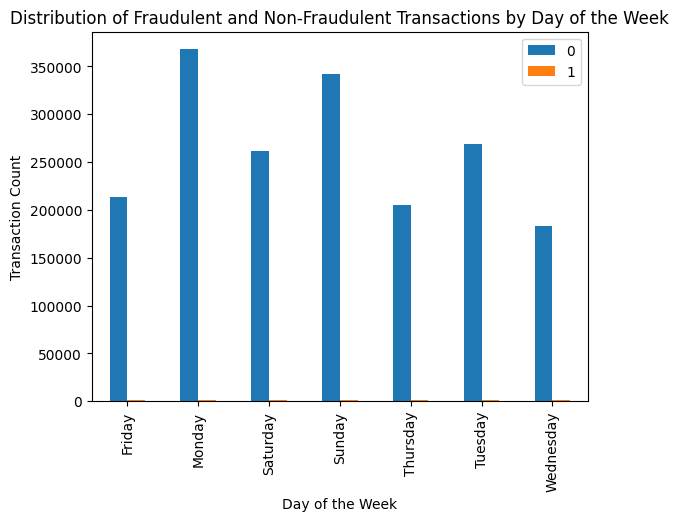

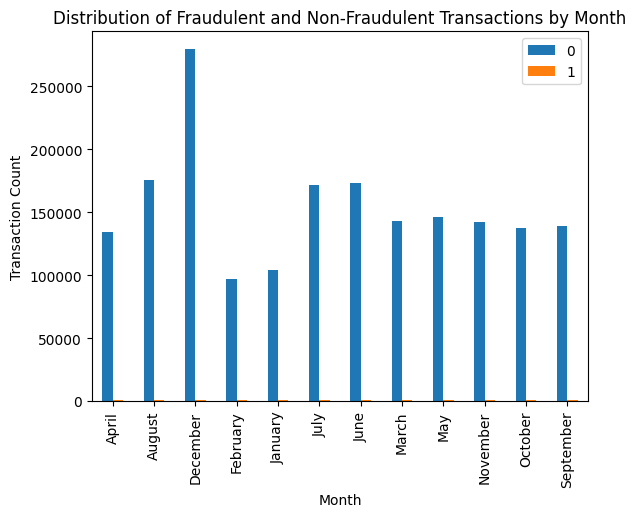

In [22]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()
df['month'] = df['trans_date_trans_time'].dt.month_name()

daily_fraud_counts = df.groupby(['day_of_week', 'is_fraud']).size().unstack(fill_value=0)
monthly_fraud_counts = df.groupby(['month', 'is_fraud']).size().unstack(fill_value=0)

daily_fraud_counts.plot(kind='bar')
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Transaction Count')
plt.legend()
plt.show()

monthly_fraud_counts.plot(kind='bar')
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Transaction Count')
plt.legend()
plt.show()


The plots above show the distribution of fraudulent and non-fraudulent transactions occurring on each day of the week and month of the year. There seem to be more fraudulent transactions that occur on Sundays and Mondays as well as in December.

# 9. Compared to any other time of the year, how prevalent are fraudulent transactions during the holidays (11-30 to 12-31)? During post-holidays (1-1 to 2-28)? During the summer (05-24 to 09-01)?

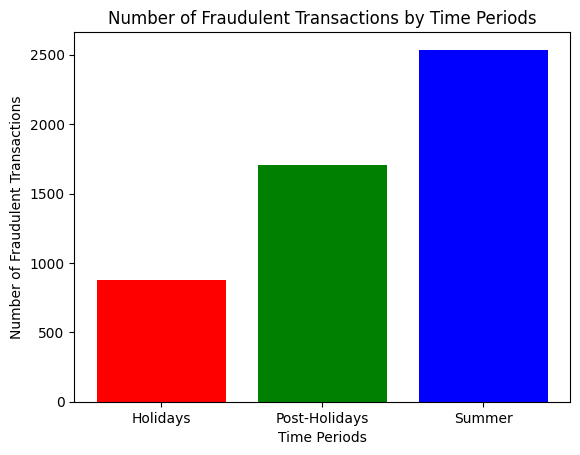

In [23]:
holidays = []
post_holidays = []
summer = []

df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
for index, row in df.iterrows():
    row_dt = row['trans_date_trans_time'].strftime('%m-%d')
    if (row['is_fraud'] == 1):
        if (row_dt >= '01-01') and (row_dt <= '02-28'): 
#             print(row_dt)
            post_holidays.append(row)
        elif (row_dt >= '05-24') and (row_dt <= '09-01'):
#             print(row_dt)
            summer.append(row)
        elif (row_dt >= '11-30') and (row_dt <= '12-31'):
            holidays.append(row)

categories = ['Holidays', 'Post-Holidays', 'Summer']
lengths = [len(holidays), len(post_holidays), len(summer)]

plt.bar(categories, lengths, color=['red', 'green', 'blue'])
plt.title('Number of Fraudulent Transactions by Time Periods')
plt.xlabel('Time Periods')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

The charts above show the distribution of fraudulent transactions by the time of year (post-holiday, summer, and holidays). There are more fraudulent transactions occurring in the the summer.

# 10. Is there a relationship between between "city_pop" and incidence of fraud?

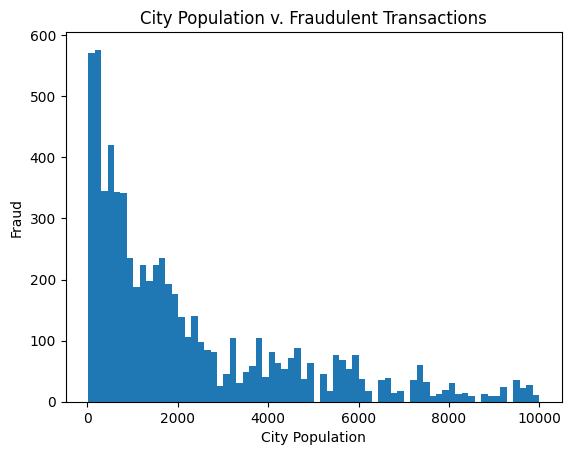

In [7]:
fraudulent_data = df[(df['is_fraud'] == 1) & (df['city_pop'] >= 0) & (df['city_pop'] <= 10000)]
plt.hist(fraudulent_data['city_pop'], bins=70)
plt.title('City Population v. Fraudulent Transactions')
plt.xlabel('City Population')
plt.ylabel('Fraud')
plt.show()


Yes, cities with lower populations have much higher rates of fraudulent transactions. This pattern can be observed in the chart above.

# 11. Are certain "job" types susceptible to fraudulent transactions?

In [25]:
df["job"].value_counts()

Film/video editor             13898
Exhibition designer           13167
Surveyor, land/geomatics      12436
Naval architect               12434
Materials engineer            11711
                              ...  
Veterinary surgeon                8
Engineer, water                   8
Contracting civil engineer        7
Ship broker                       7
Warehouse manager                 7
Name: job, Length: 497, dtype: int64

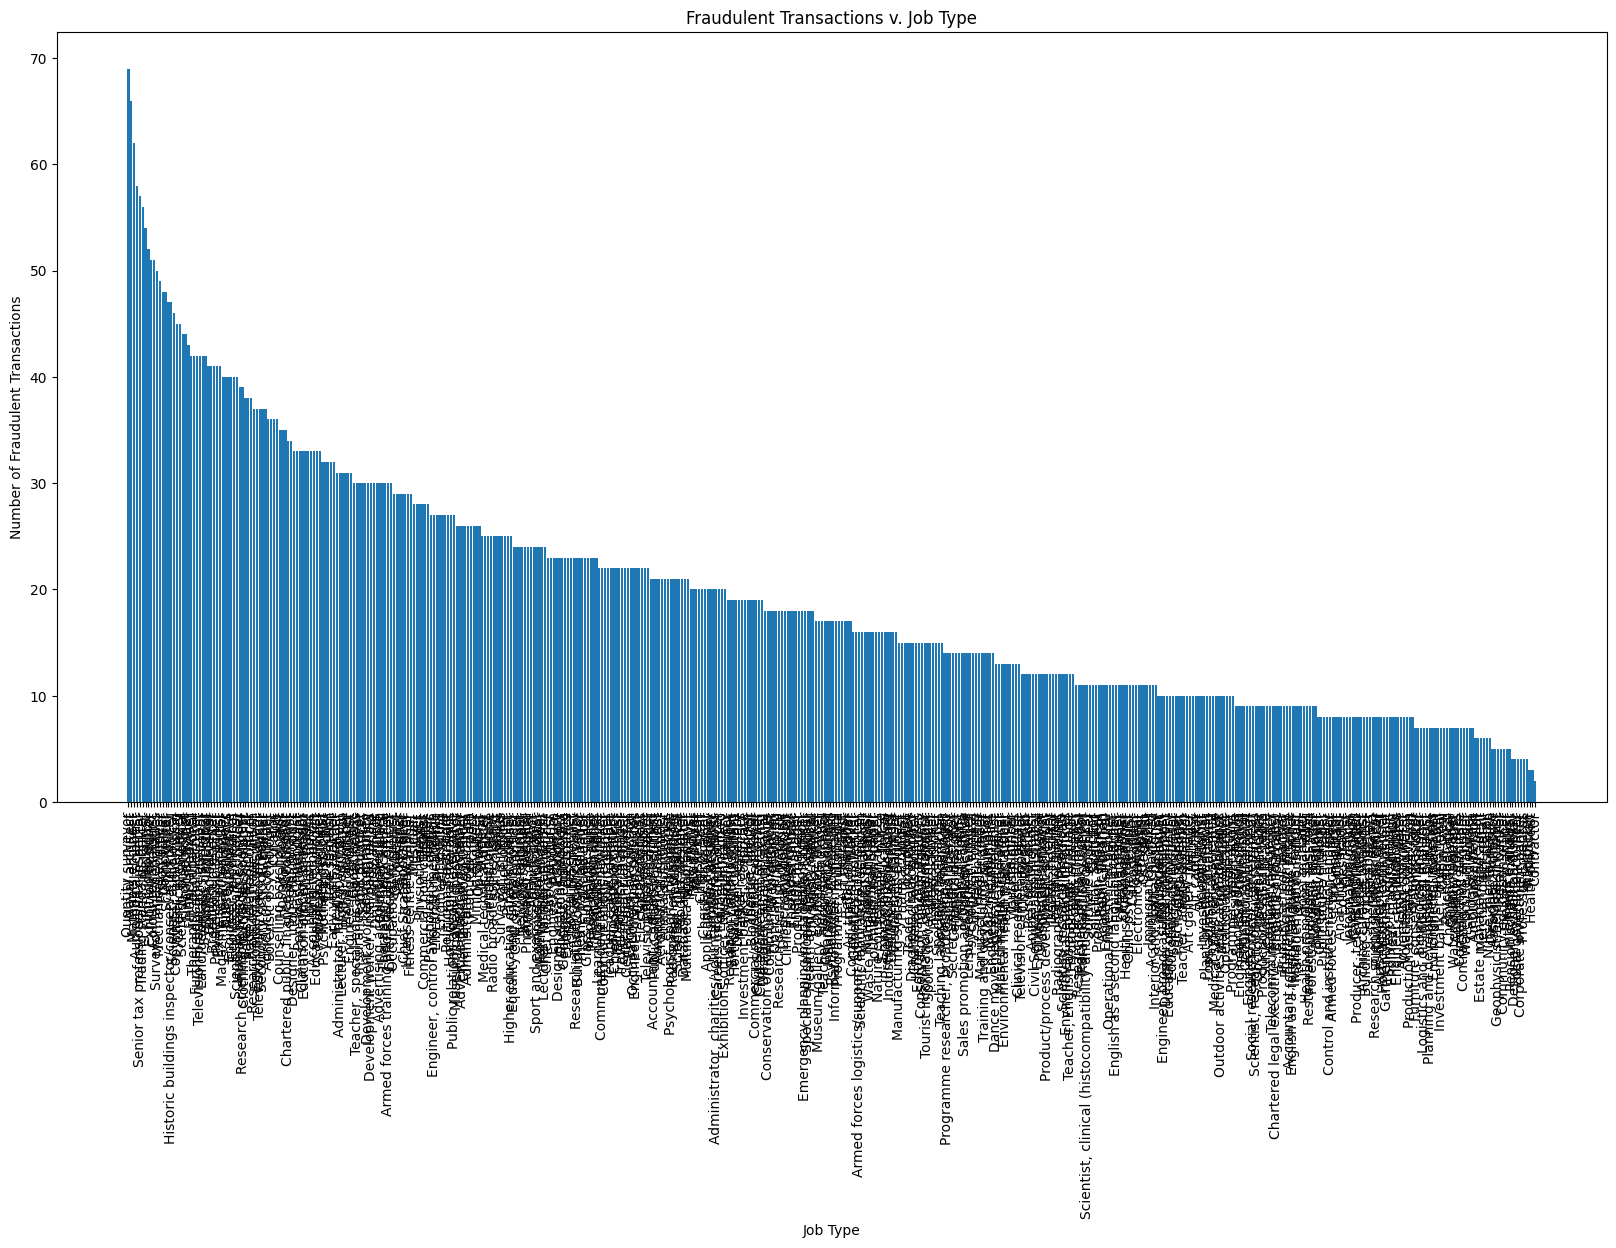

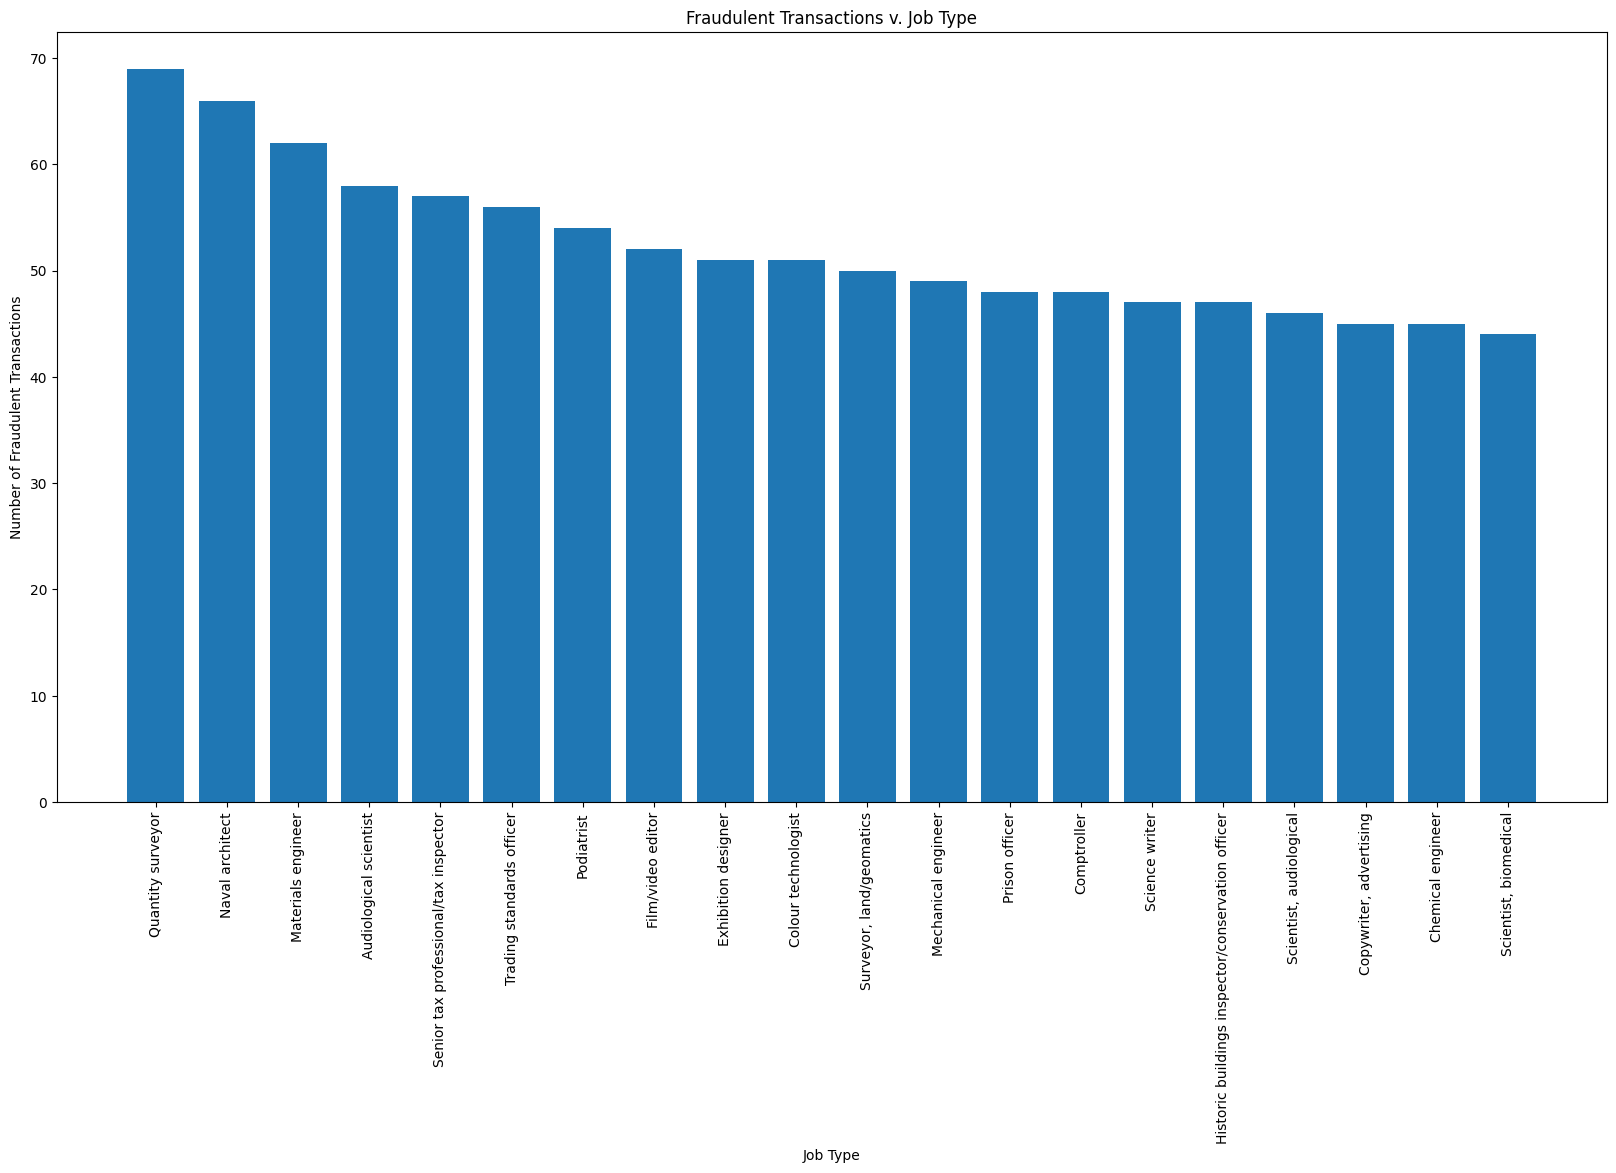

In [26]:
fraud_by_job = df[df['is_fraud'] == 1].groupby('job')['is_fraud'].count().sort_values(ascending=False)

plt.figure(figsize=(20,10))
plt.bar(fraud_by_job.index, fraud_by_job.values)
plt.title('Fraudulent Transactions v. Job Type')
plt.xlabel('Job Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(20,10))
plt.bar(fraud_by_job.index[:20], fraud_by_job.values[:20])
plt.title('Fraudulent Transactions v. Job Type')
plt.xlabel('Job Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=90)
plt.show()

In [14]:
top_jobs = df[df['is_fraud'] == 1].groupby('job')['is_fraud'].count().sort_values(ascending=False).head(35)
top_jobs_list = top_jobs.index.tolist()
print("Top 35 jobs with the highest number of fraudulent transactions:")
print(top_jobs_list)

Top 35 jobs with the highest number of fraudulent transactions:
['Quantity surveyor', 'Naval architect', 'Materials engineer', 'Audiological scientist', 'Senior tax professional/tax inspector', 'Trading standards officer', 'Podiatrist', 'Film/video editor', 'Exhibition designer', 'Colour technologist', 'Surveyor, land/geomatics', 'Mechanical engineer', 'Prison officer', 'Comptroller', 'Science writer', 'Historic buildings inspector/conservation officer', 'Scientist, audiological', 'Copywriter, advertising', 'Chemical engineer', 'Scientist, biomedical', 'Archaeologist', 'Financial trader', 'Financial adviser', 'Therapist, occupational', 'Further education lecturer', 'Television production assistant', 'Land/geomatics surveyor', 'Systems developer', 'Buyer, industrial', 'Building surveyor', 'Broadcast presenter', 'Private music teacher', 'Exercise physiologist', 'Magazine features editor', 'Energy engineer']


There isn’t a clear pattern where one job type has a much higher rate. However, the job types can be sorted and we see there are some jobs that generally have more fraudulent transactions. The second chart shows 35 of the top job types by fraudulent transactions.